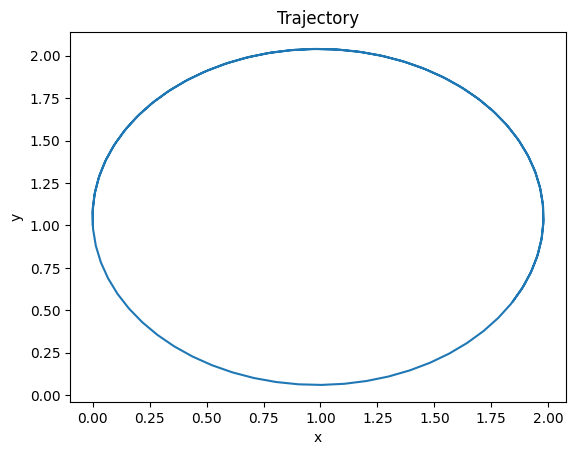

In [13]:
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad

def dyn(s,u):
    return np.array([u[0], u[1]])


def integrate(f,xt,dt,u):
    # Finds next point 
    next_x = xt + f(xt,u)*dt; 
    return next_x


def init_traj(f,x0,tspan,dt,integrate,u):
    N = int((max(tspan)-min(tspan))/dt)
    t = np.linspace(0,T,N)    
    x = np.copy(x0)
    xtraj = np.zeros((len(x0),N))
    xtraj[:,0]=np.copy(x0)
    for i in range(1,N):
        xtraj[:,i]=integrate(f,x,dt,u[:,i])
        x = np.copy(xtraj[:,i])
    
    return xtraj


def calc_P(args,Q,R,P1, a_list):
    t = np.arange(0,T, dt)

    P = P1
    Rinv = np.linalg.inv(R)
    P1 = np.zeros(np.shape(P1))
    r = -np.array([[0.,0.]]).T

    list_P, list_r = np.zeros((t.size,2,2)), np.zeros((t.size,2,1))
    list_P[0], list_r[0] = P1, r

    time = 0
    
    A = np.array([[0, 0], [0, 0]])
    B = np.array([[1., 0.], [0., 1.]])
    for i in range(t.size-1):
        x = np.array([args[0:2,t.size-2-i]])
        u = np.array([args[2:4,t.size-2-i]])

        P_dot =P@A + np.transpose(A)@P - P@(B@Rinv@np.transpose(B))@P + Q

        a = a_list[i]

        b = np.transpose(u@(R))
        r_dot = np.transpose(A- B@Rinv@np.transpose(B)@P)@r + a - (P@B@Rinv)@b

        r += dt*r_dot
        P += dt*P_dot

        list_P[i+1], list_r[i+1] = P, r
        time+= dt 
    list_P, list_r = np.flip(list_P, 0), np.flip(list_r, 0)
    return list_P, list_r

def desc_dir(P_list, r_list, args, Q, R, P1p, per):
    t = np.arange(0,T, dt)
    z = np.array([[0.0],[0.0]])
    P1 = np.ones(np.shape(P1p))
    P1[:,:] = P1p[:,:]
    Rinv = np.linalg.inv(R)
    zeta = np.zeros((t.size,4,1))

    A = np.array([[0, 0], [0, 0]])
    B = np.array([[1., 0.], [0., 1.]])

    for i in range(t.size -1):
        r, P = r_list[i], P_list[i]
        u = np.array([args[2:4,i]])
        b = np.transpose(u@(R))
        v = -Rinv@np.transpose(B)@P@z - Rinv@B.T@r- Rinv@b
        
        zeta[i] = np.vstack((z,v))
        zdot = A@z + B@v
        z += zdot*dt
    return zeta


def DJ(zeta, args,Q,R,P1, a_list):
    t = np.arange(0,T, dt)
    J = np.zeros((t.size))
    for i in range(t.size-1):
        z = zeta[i,:2]
        a = np.transpose(a_list[i])
        u = np.array([args[2:4,i]])
        v = zeta[i,2:]
        J_val = a@z + u@(R)@v
        J[i] = J_val[0][0]
    trapz = np.trapz(J,dx=dt)
    return trapz


def get_hk(k):
    hk = dblquad(lambda x1, x2: 
                    ((np.cos(k[0]*np.pi*x1/L1)**2)*np.cos(k[1]*np.pi*x2/L2)**2), 
                    0, L1, lambda x1: 0, lambda x1: L2, epsabs=1.49e-01, epsrel=1.49e-01)
    return np.sqrt(hk[0])


def get_Fk(hk,x,k):
    k1, k2 = k[0], k[1]
    x1, x2 = x[0][0], x[1][0]  
    Fk = (1/hk)*(np.cos(k1*np.pi*x1/L1))*(np.cos(k2*np.pi*x2/L2))
    return Fk


def get_ck(x_traj,dt,T,hk, k):
    n, _, _ = np.shape(x_traj)
    add = np.zeros(n)
    for i in range(n):
        x = x_traj[i] 
        Fk = get_Fk(hk,x,k)
        add[i] = Fk
    ck = (1/T)*np.trapz(add,dx=dt)
    return ck


def get_ck_arr(traj,dt,T, hk_arr, K):
    traj = np.expand_dims(np.transpose(traj), 2)
    ck_arr = np.zeros((K,K))
    for k1 in range(0,K):
        for k2 in range(0,K):
            k = [k1, k2]
            hk = hk_arr[k1][k2]
            ck_arr[k1][k2] =  get_ck(traj,dt,T,hk, k)
    return ck_arr


T = 10
tspan = [0, T]
dt = 0.1
N = int((max(tspan)-min(tspan))/dt)

x0 = np.array([0,1])

u1_array, u2_array = 0.1*np.ones(N), -0.5*np.ones(N)
u = np.vstack((u1_array,u2_array))

traj_initial = init_traj(dyn,x0,tspan,dt,integrate,u)
traj_initial = np.vstack((traj_initial,u1_array))
traj_initial = np.vstack((traj_initial,u2_array))

q = 10
Q = np.array([[1.0,0.0],[0.0, 1.0]])
R = np.array([[1.0,0.0],[0.0, 0.1]])
P1 = np.zeros((2,2))

ll1, ll2 = 0, 0
ul1, ul2 = 2, 2
L1 = ul1 - ll1 
L2 = ul2 - ll2
K = 10

hk_arr = np.zeros((K,K))
phi_k_arr = np.zeros((K,K))
lambda_arr = np.zeros((K,K))

Sigma = np.eye(2)*2


for k1 in range(0, K):
    for k2 in range(0, K):
        k = [k1,k2]
        hk = get_hk(k)
        phi_k = dblquad(lambda x1, x2: ((1/hk)*(np.cos(k[0]*np.pi*x1/L1))*np.cos(k[1]*np.pi*x2/L2)*(np.linalg.det(2*np.pi*Sigma))**(-0.5))*(np.exp(-0.5*(x1**2+x2**2))), ll1, ul1, lambda x1: ll2, lambda x1: ul2, epsabs=1.49e-01, epsrel=1.49e-01)[0]
        hk_arr[k1][k2] = hk
        phi_k_arr[k1][k2] = phi_k
        lambda_arr[k1][k2] = (1+np.linalg.norm(k)**2)**(-3/2)  


def get_DF(x, k1, k2, hk):
    x1, x2 = x[0][0], x[1][0]
    a, b = k1*np.pi/L1, k2*np.pi/L2
    return np.array([[np.cos(b*x2)*np.sin(a*x1)*(-a)/hk], [np.cos(a*x1)*np.sin(b*x2)*(-b)/hk]])
        

def get_a_list(traj,ck_arr,phi_k_arr, lambda_arr, K, Q):
    traj = np.expand_dims(np.transpose(traj), 2)
    n, _, _  = np.shape(traj)
    a_list = np.zeros((n,2,1))
    for i in range(n):
        x = traj[i]
        add = np.zeros((2,1))
        
        for k1 in range(K):
            for k2 in range(K):
                hk = hk_arr[k1][k2]
                Df = get_DF(x, k1, k2, hk)
                add += (lambda_arr[k1][k2]*2*(ck_arr[k1][k2] - phi_k_arr[k1][k2]))*Df/T
        a_list[i] = q*add 
    return a_list      

t_array = np.linspace(0, 10, N)
x0 = np.array([0, 1])
u = np.zeros([2, N])
x_ref = np.zeros([2,N])
x_ref[:,0] = x0
for i in range(N):
    u[:,i] = np.array([np.sin(t_array[i]), np.cos(t_array[i])])

for i in range(1,N):
    x_ref[:,i] = x_ref[:,i-1] + dt*u[:,i-1]

circle_traj = np.vstack((x_ref, u))
traj = circle_traj
alpha = 0.35
beta = 0.8
eps = 0.001
i = 0

plt.figure()
plt.title("Trajectory")
plt.plot(traj[0,:],traj[1,:])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [14]:
ck_arr = get_ck_arr(traj,dt,T, hk_arr,K)
a_list = get_a_list(traj,ck_arr,phi_k_arr, lambda_arr, K, Q)
P_list, r_list = calc_P(traj,Q,R,P1,a_list)

per = 0.0
zeta = desc_dir(P_list,r_list,traj_initial,Q,R,P1, per)

norm_zeta = DJ(zeta,traj_initial,Q,R,P1,a_list)

old_dj = DJ(zeta,traj,Q,R,P1,a_list)
while True:
    ck_arr = get_ck_arr(traj,dt,T, hk_arr,K)
    a_list = get_a_list(traj,ck_arr,phi_k_arr, lambda_arr, K, Q)
    P_list, r_list = calc_P(traj,Q,R,P1,a_list)
    
    zeta = desc_dir(P_list,r_list,traj,Q,R,P1,per)

    gamma = 0.1
    traj_a = np.zeros(np.shape(traj))
    traj_a[:] = traj[:]
    x = np.array([traj[0:2,:]])
    u = np.array([traj[2:4,:]])
    v = np.transpose(zeta[:,2:4])
    u_p = u + gamma*v
    u_p = u_p[0]

    x0 = x[0,:,0]
    traj_a[0:2,:] = init_traj(dyn,x0,tspan,dt,integrate,u_p)
    traj_a[2:4,:] = u_p
    traj[0:2] = traj_a[0:2]
    traj[2:4] = traj_a[2:4] 
    i = i+1
    
    val = abs(DJ(zeta,traj,Q,R,P1,a_list))

    print("DJ =",val)
    #print("zeta norm:",np.linalg.norm(zeta))

    if val < eps:
        break

DJ = 2.005553802695221
DJ = 1.8324871172674015
DJ = 1.6750732914126583
DJ = 1.5319110576084862
DJ = 1.4013989944765939
DJ = 1.2820339535799017
DJ = 1.1724604381848278
DJ = 1.0715698266447382
DJ = 0.9785146654970349
DJ = 0.892602792721538
DJ = 0.8132100639316286
DJ = 0.7397810029740397
DJ = 0.6718578827541068
DJ = 0.609068999559411
DJ = 0.5510736706584313
DJ = 0.4975144639166138
DJ = 0.44801798149793354
DJ = 0.4022375402038181
DJ = 0.3599006034105171
DJ = 0.3208281864513227
DJ = 0.2849143863690149
DJ = 0.25207701436214686
DJ = 0.22220665719032315
DJ = 0.1951411554131804
DJ = 0.17067421035798425
DJ = 0.14858553003130714
DJ = 0.12867186768746566
DJ = 0.11076480406240856
DJ = 0.09473210397337753
DJ = 0.08046680765471328
DJ = 0.06787070572704959
DJ = 0.05683855688968876
DJ = 0.04724783865249611
DJ = 0.03895640664667632
DJ = 0.031807601096195334
DJ = 0.025639998850955407
DJ = 0.020298078087706638
DJ = 0.01564072113349636
DJ = 0.011546068612643175
DJ = 0.007912806423148167
DJ = 0.004658898862

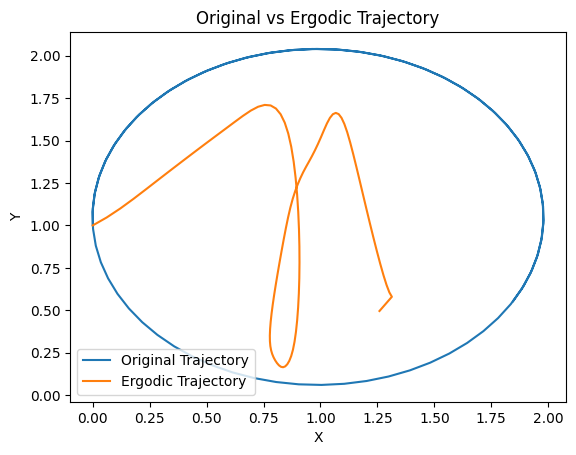

In [15]:
plt.plot(x_ref[0], x_ref[1], label = 'Original Trajectory')
plt.title("Original vs Ergodic Trajectory")
plt.plot(traj[0,:],traj[1,:], label = 'Ergodic Trajectory')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()